In [7]:
import os
from pathlib import Path

cwd = Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent)

In [8]:
import pandas as pd
from mllm_emotion_classifier.utils import (
    add_fairness_metrics_to_df,
    plot_fairness_vs_hparam,
    plot_fairness_by_emotion,
    FigureCollector,
)
from EmoBox.EmoBox import EmoDataset

In [9]:
hparam = 'top_p' # or 'top_p'
assert hparam in ['temperature', 'top_p'], "hparam must be either 'temperature' or 'top_p'"

dataset = 'iemocap'
fold = None # Set to an integer fold number if needed, else None to aggregate all folds
sensitive_attr = 'gender' # gender, age, ethnicity, race
model = 'qwen2-audio-instruct'

metadata_dir = Path('EmoBox/data/')
dataset_path = metadata_dir / dataset
n_folds = len([d for d in dataset_path.iterdir() if d.is_dir() and d.name.startswith("fold_")])
out_dir = Path('outputs') / "temperature_runs" if hparam == 'temperature' else Path('outputs') / "topp_runs"

test = EmoDataset(dataset, './', metadata_dir, fold=1, split="test")
emotions = set(test.label_map.values())

if fold is None:
    dfs = []
    for f in range(1, n_folds + 1):
        results_csv = out_dir / model / dataset / f'fold_{f}.csv'
        df_fold = pd.read_csv(results_csv)
        dfs.append(df_fold)
    df = pd.concat(dfs, ignore_index=True)
else:
    results_csv = out_dir / model / dataset / f'fold_{fold}.csv'
    df = pd.read_csv(results_csv)

print(len(df), "rows")
df.head(5)

since there is no official valid data, use random split for train valid split, with a ratio of [80, 20]
load in 4446 samples, only 4446 exists in data dir EmoBox/data
load in 1085 samples, only 1085 exists in data dir EmoBox/data
Num. training samples 4446
Num. valid samples 0
Num. test samples 1085
Using label_map {'neu': 'Neutral', 'hap': 'Happy', 'ang': 'Angry', 'sad': 'Sad', 'exc': 'Happy'}
250 rows


,run,dataset,fold,model,prompt,top_p,valid_rate,global_f1_macro,global_f1_weighted,global_accuracy_unweighted,...,language_English_classwise_positive_predictive_value_Neutral,language_English_classwise_positive_predictive_value_Sad,language_English_classwise_negative_predictive_value_Angry,language_English_classwise_negative_predictive_value_Happy,language_English_classwise_negative_predictive_value_Neutral,language_English_classwise_negative_predictive_value_Sad,language_English_classwise_f1_score_Angry,language_English_classwise_f1_score_Happy,language_English_classwise_f1_score_Neutral,language_English_classwise_f1_score_Sad
0,0,iemocap,1,qwen2-audio-instruct,user_labels,0.0001,1.0,0.7656,0.7630,0.7602,...,0.7021,0.6806,0.9502,0.8965,0.8773,0.9459,0.8605,0.7407,0.7442,0.7171
1,0,iemocap,1,qwen2-audio-instruct,user_labels,0.3000,1.0,0.7643,0.7614,0.7570,...,0.6977,0.7050,0.9545,0.8936,0.8806,0.9401,0.8690,0.7273,0.7451,0.7157
2,0,iemocap,1,qwen2-audio-instruct,user_labels,0.5000,1.0,0.7600,0.7567,0.7571,...,0.6974,0.6578,0.9533,0.8947,0.8656,0.9465,0.8624,0.7402,0.7311,0.7064
3,0,iemocap,1,qwen2-audio-instruct,user_labels,0.7000,1.0,0.7487,0.7448,0.7516,...,0.7018,0.6160,0.9541,0.8898,0.8484,0.9521,0.8552,0.7305,0.7152,0.6937
4,0,iemocap,1,qwen2-audio-instruct,user_labels,1.0000,1.0,0.5393,0.6720,0.6814,...,0.6418,0.4625,0.9483,0.8528,0.8063,0.9399,0.8288,0.6469,0.6451,0.5759


In [10]:
emotions

{'Angry', 'Happy', 'Neutral', 'Sad'}

In [11]:
run = None
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='statistical_parity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_opportunity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='equal_non_opportunity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='predictive_parity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='negative_predictive_parity', run=run)
df = add_fairness_metrics_to_df(df, emotions, sensitive_attr=sensitive_attr, fairness_name='overall_accuracy_equality', run=run)

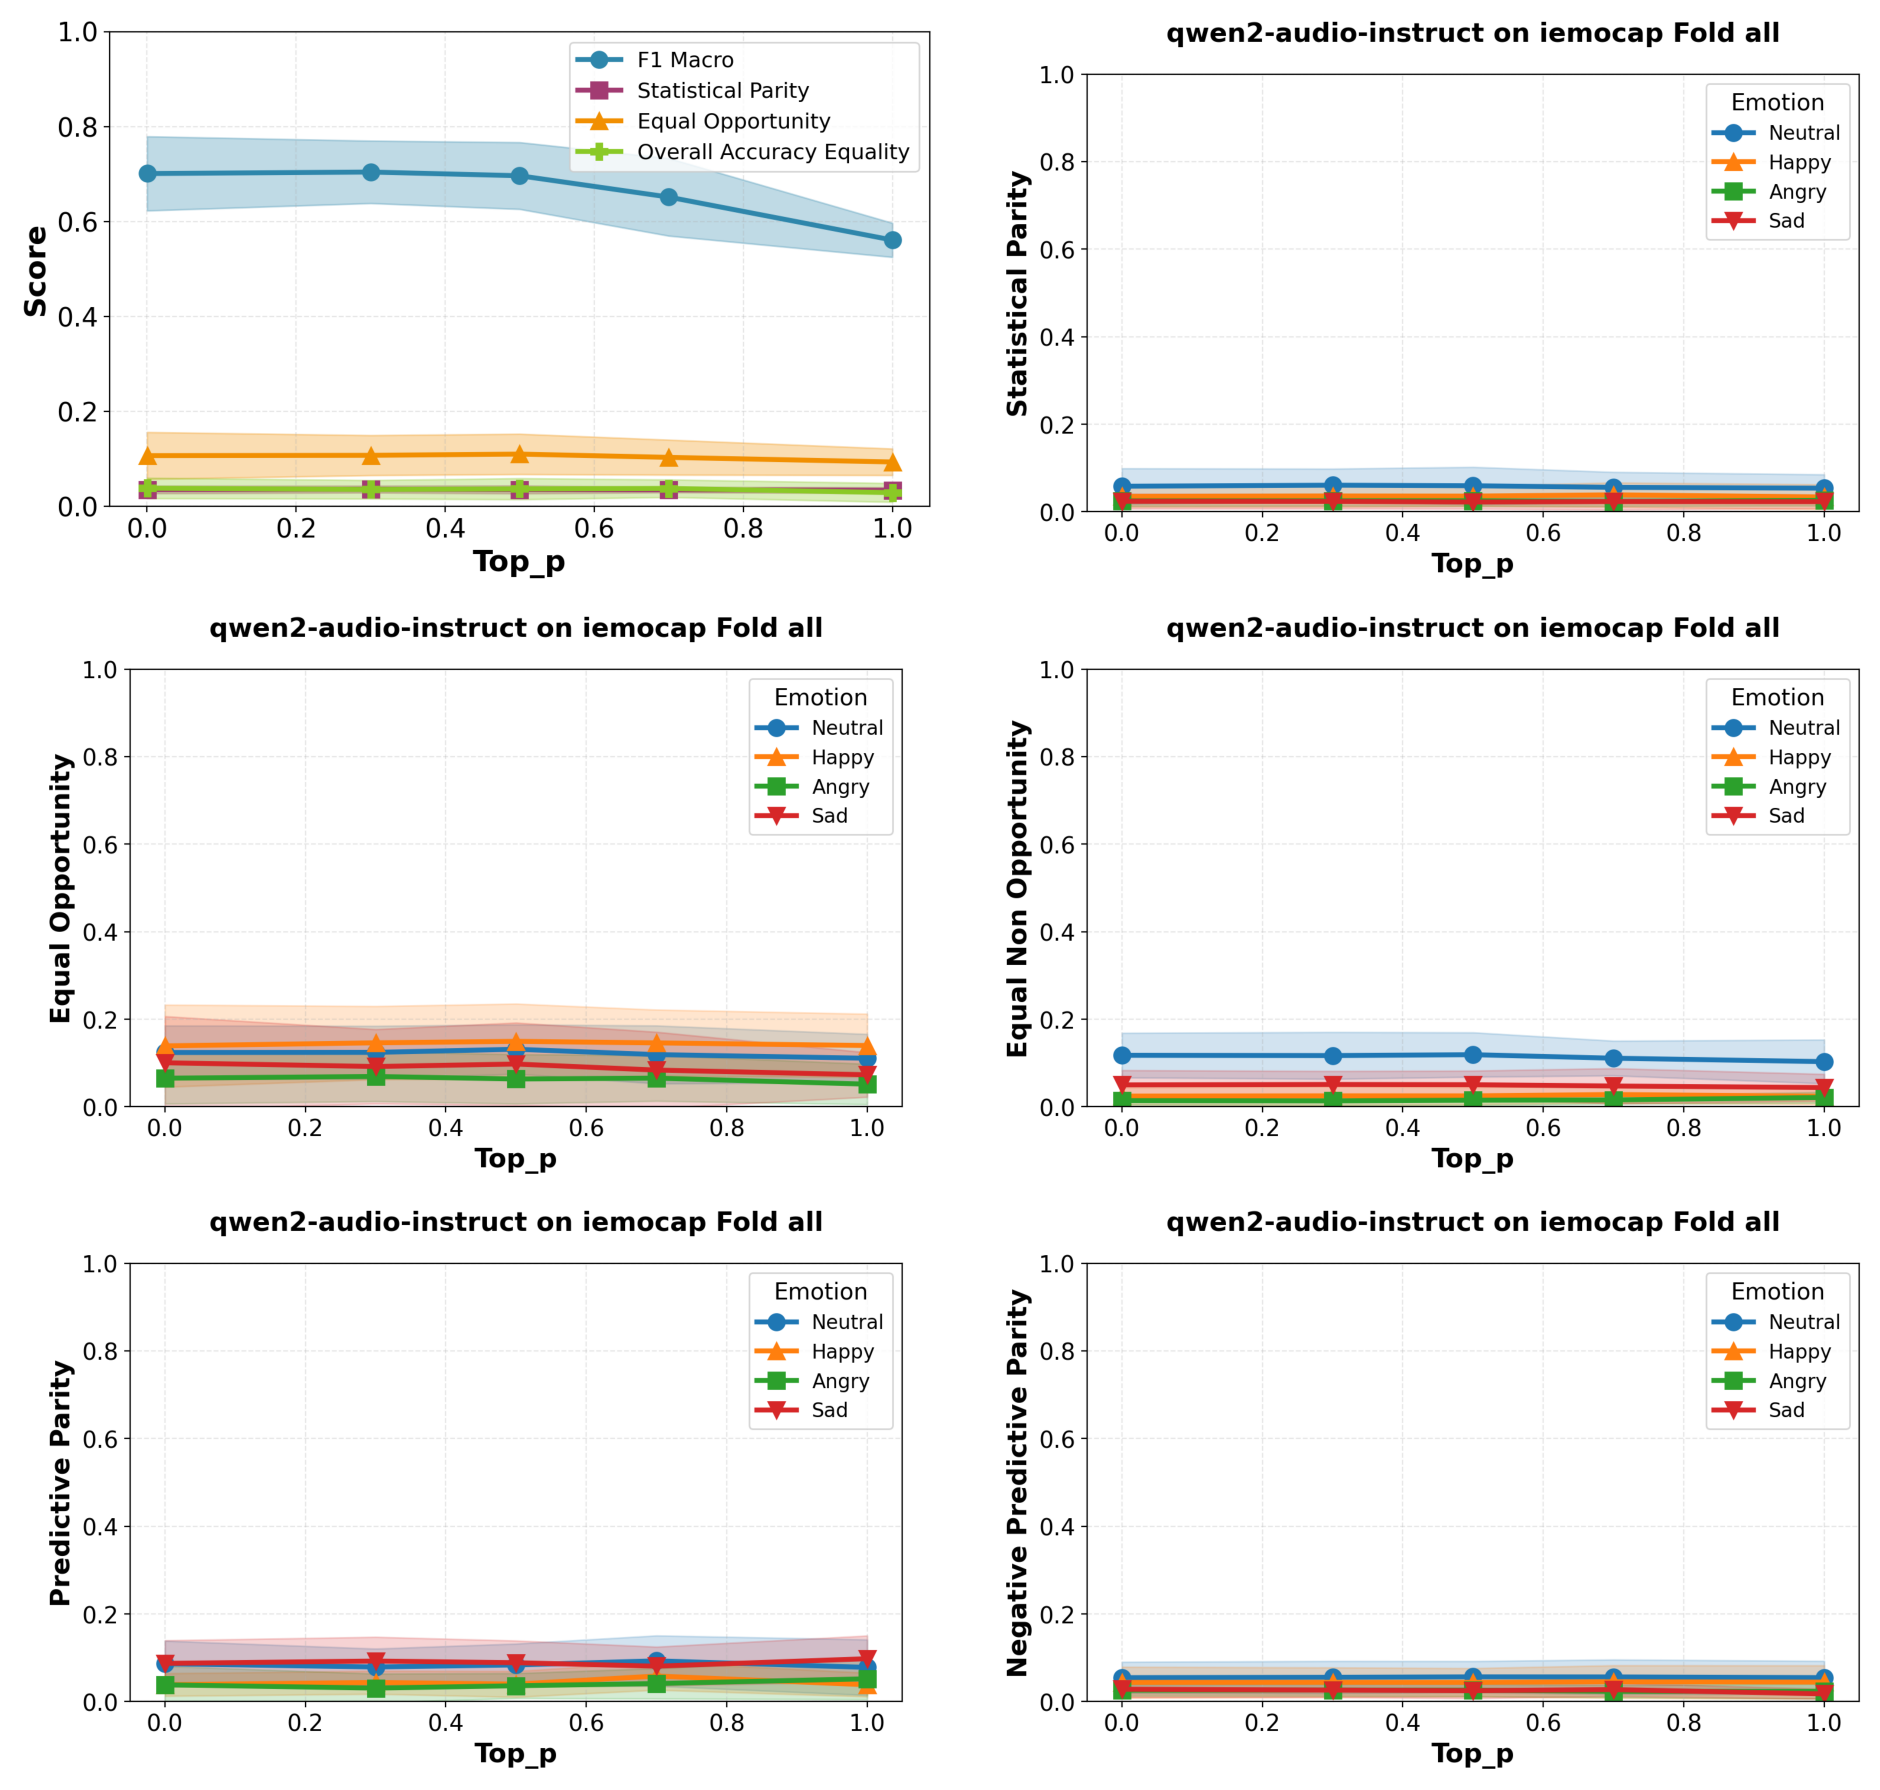

In [12]:
show_std = True
fold = fold if fold is not None else 'all'
outpath = out_dir / model / dataset / f'f1_fairness_{sensitive_attr}_fold_{fold}.png'
with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, ['statistical_parity', 'equal_opportunity', 'overall_accuracy_equality'], model, dataset, fold, show_std=show_std, output_path=outpath)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_non_opportunity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'predictive_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'negative_predictive_parity', model, dataset, fold, show_std=show_std)
    
collector.display_grid(nrows=3, ncols=2, figsize=(20, 18))
        # , title=f'Fairness Metrics by Emotion - {model} on {dataset} Fold {fold}')

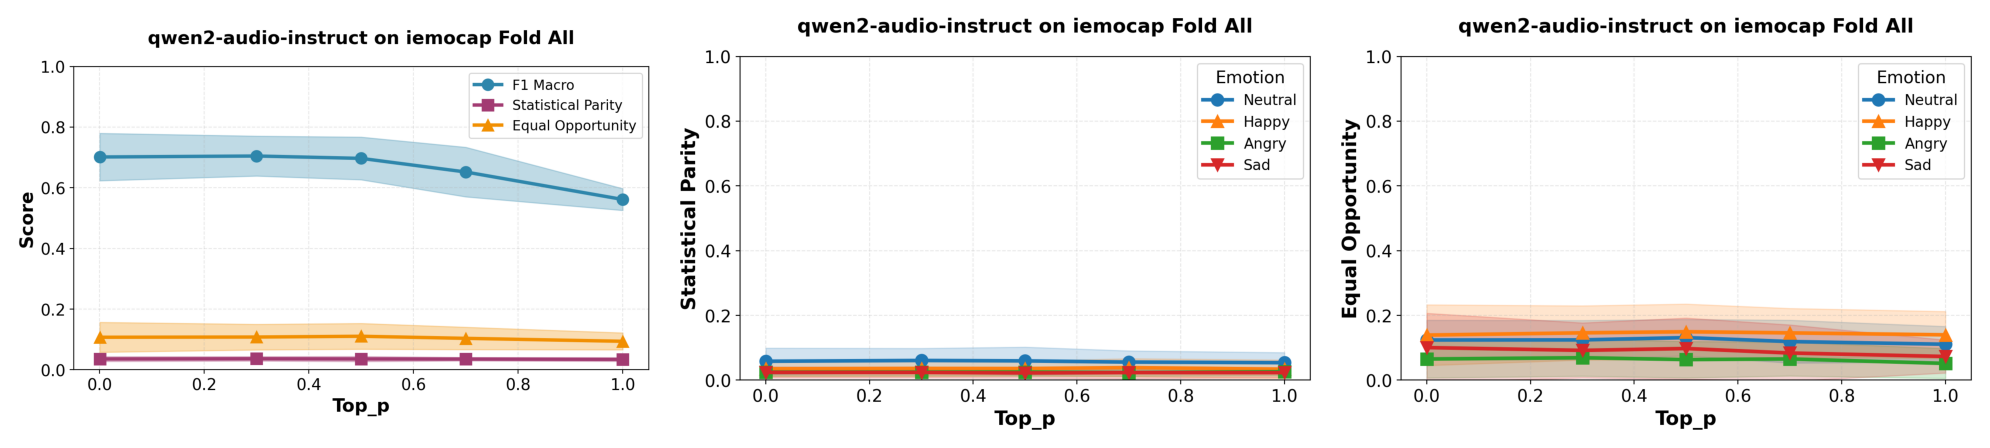

In [7]:
show_std = True
with FigureCollector() as collector:
    plot_fairness_vs_hparam(df, hparam, ['statistical_parity', 'equal_opportunity'], model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'statistical_parity', model, dataset, fold, show_std=show_std)
    plot_fairness_by_emotion(df, emotions, hparam, 'equal_opportunity', model, dataset, fold, show_std=show_std)
    
collector.display_grid(nrows=1, ncols=3, figsize=(20, 18))